<a href="https://colab.research.google.com/github/SimeonHristov99/AI_Traffic_Sign_Classifier_Tensorflow/blob/main/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

## Traffic Sign Classifier

### The goal of this project is to build and train a traffic sign classifier. Results were generated in the context of the second  stage  of  the [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) dataset. The classifier is a convolutional neural network and is implemented using the deep learning framework [Keras](https://keras.io/) from the [TensorFlow](https://www.tensorflow.org/) library.

### Inspired by:
- [CNN Design for Real-Time Traffic Sign Recognition](https://www.sciencedirect.com/science/article/pii/S1877705817341231)
- [Man vs. computer: benchmarking machine learning algorithms for traffic sign recognition](https://christian-igel.github.io/paper/MvCBMLAfTSR.pdf)

In [166]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Loading data

In [167]:
# # # Run one time only. Requires Kaggle API access key to download the dataset.
# !pip install -q kaggle

# import os
# from google.colab import drive

# drive.mount('/gdrive')

# assert os.getcwd() == '/content'

# os.environ['KAGGLE_CONFIG_DIR'] = '../gdrive/MyDrive/kaggle'

# !kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign -p /content/data/ --unzip

In [168]:
traindf = pd.read_csv('/content/data/Train.csv',dtype=str)

In [169]:
BATCH_SIZE = 50
IM_SIZE = 28
CLASSES = 43
TRAIN_DATA_DIR = '/content/data'

train_datagen = ImageDataGenerator(
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.05, # set validation split tf.image.rgb_to_grayscale,
    # rescale=1./255.
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_DATA_DIR,
    x_col='Path',
    y_col='ClassId',
    seed=42,
    batch_size=BATCH_SIZE,
    subset='training', # set as training data
    target_size=(IM_SIZE, IM_SIZE)
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_DATA_DIR,
    x_col='Path',
    y_col='ClassId',
    seed=42,
    batch_size=BATCH_SIZE,
    subset='validation', # set as training data
    target_size=(IM_SIZE, IM_SIZE)
)

print(f'{len(train_generator)} training batches. Each with {train_generator[0][0].shape[0]} images.')
print(f'{len(val_generator)} validation batches. Each with {val_generator[0][0].shape[0]} images.')

Found 37249 validated image filenames belonging to 43 classes.
Found 1960 validated image filenames belonging to 43 classes.
745 training batches. Each with 50 images.
40 validation batches. Each with 50 images.


# Visualizing data

In [170]:
X_train_batch, y_train_batch = next(train_generator)
X_val_batch, y_val_batch = next(val_generator)

print(type(X_train_batch), X_train_batch.shape, type(y_train_batch), y_train_batch.shape)
print(type(X_val_batch), X_val_batch.shape, type(y_val_batch), y_val_batch.shape)

<class 'numpy.ndarray'> (50, 28, 28, 3) <class 'numpy.ndarray'> (50, 43)
<class 'numpy.ndarray'> (50, 28, 28, 3) <class 'numpy.ndarray'> (50, 43)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

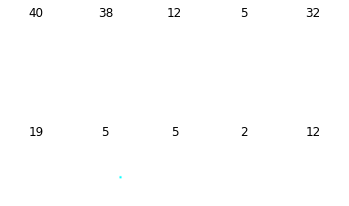

In [171]:
for i in range(10):
  plt.subplot(2, 5, i + 1)

  rand_idx = np.random.randint(X_train_batch.shape[0])
  image = X_train_batch[rand_idx]
  
  plt.imshow(image)
  plt.axis('off')
  plt.title(np.argmax(y_train_batch[rand_idx]))

plt.show()

# Choosing a model

In [175]:
input_shape = X_train_batch[0].shape

# model = keras.Sequential([
#  keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
#  keras.layers.MaxPool2D(),
#  keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
#  keras.layers.MaxPool2D(),
#  keras.layers.Flatten(),
#  keras.layers.Dropout(0.5),
#  keras.layers.Dense(units=CLASSES, activation='softmax')
# ])

model = keras.models.Sequential([ # lenet_5_model
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='relu', input_shape=input_shape, padding='same'), #C1
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(), #S2
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(), #S4
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(), #Flatten
    keras.layers.Dropout(0.5),
    keras.layers.Dense(CLASSES, activation='softmax') #Output layer
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_184 (Conv2D)          (None, 28, 28, 6)         456       
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 14, 14, 16)        2416      
_________________________________________________________________
batch_normalization_17 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 7, 7, 16)        

# Training

In [176]:
model.fit(
    x=train_generator,
    validation_data=val_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = val_generator.samples // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
744/744 [==============================] - 13s 17ms/step - loss: 2.4720 - accuracy: 0.4027 - val_loss: 4.6419 - val_accuracy: 0.1508
Epoch 2/10
744/744 [==============================] - 12s 17ms/step - loss: 0.9022 - accuracy: 0.7282 - val_loss: 4.9908 - val_accuracy: 0.2903
Epoch 3/10
744/744 [==============================] - 13s 17ms/step - loss: 0.6237 - accuracy: 0.8084 - val_loss: 5.0779 - val_accuracy: 0.5174
Epoch 4/10
744/744 [==============================] - 12s 17ms/step - loss: 0.5107 - accuracy: 0.8414 - val_loss: 5.4272 - val_accuracy: 0.4662
Epoch 5/10
744/744 [==============================] - 12s 17ms/step - loss: 0.4582 - accuracy: 0.8585 - val_loss: 6.0550 - val_accuracy: 0.3415
Epoch 6/10
744/744 [==============================] - 13s 17ms/step - loss: 0.4137 - accuracy: 0.8711 - val_loss: 5.8551 - val_accuracy: 0.4154
Epoch 7/10
744/744 [==============================] - 13s 17ms/step - loss: 0.3960 - accuracy: 0.8777 - val_loss: 6.1998 - val_accuracy:

# Evaluation

In [174]:
# Coming soon ...